<h1>Titantic Survival Classifier</h1>
<p>Haley Johnson, SI 370 Homework 5</p>

<ul>
    <li><a href = "https://www.kaggle.com/competitions/titanic/overview">Kaggle Competition</a></li>
    <li><a href = "https://github.com/haleyej/SI_370_homework_5">GitHub Repo</a></li>
</ul>

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
sns.set(style = 'darkgrid', context = 'notebook')

<h2>Exploratory Data Analysis</h2>

In [3]:
df = pd.read_csv("data/train.csv")

<p><b>p class:</b> the passenger's ticket class</p>
<p><b>sibsp:</b> number of siblings / spouses aboard</p>
<p><b>parch:</b> number of parents / children aboard</p>
<p><b>embarked:</b> port where passenger got on the ship</p>
<ul>
    <li><b>c:</b> cherbourg</li>
    <li><b>q:</b> queenstown</li>
    <li><b>s:</b> south hampton</li>
</ul>

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.shape

(891, 12)

In [6]:
df.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
df.describe(exclude = [np.number]).T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


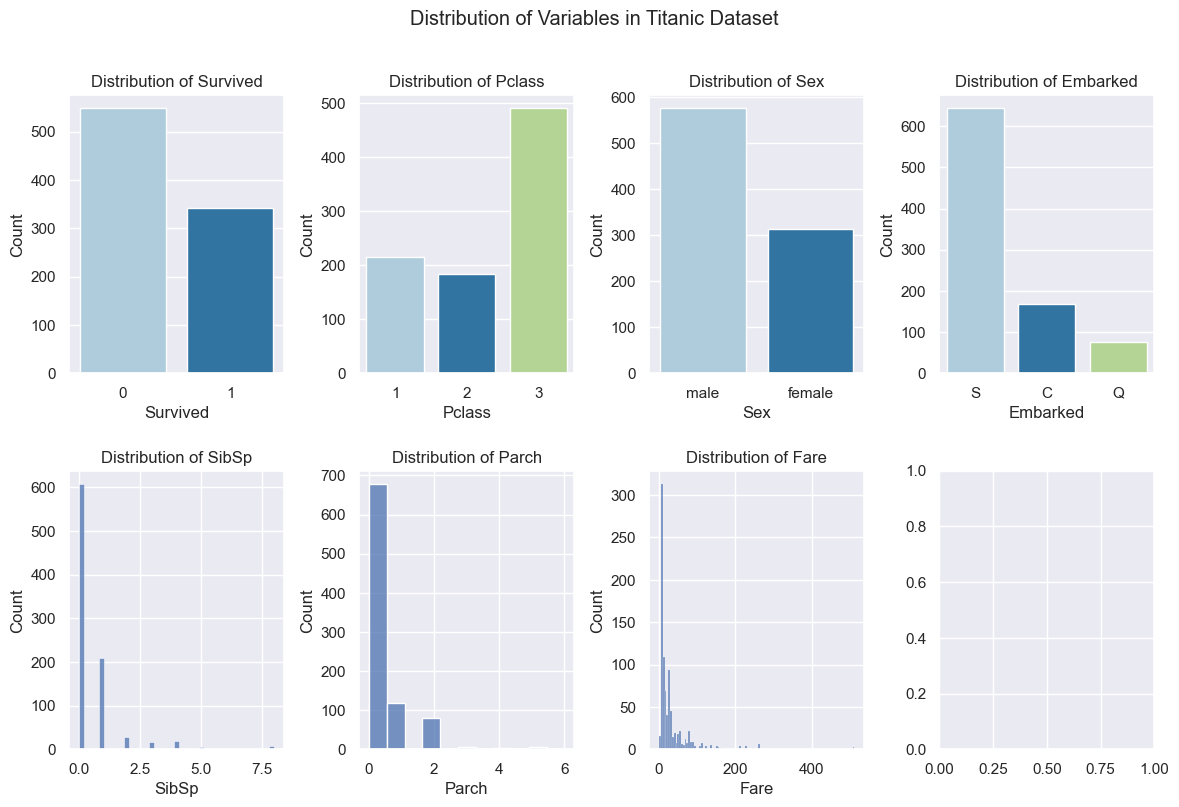

In [8]:
sns.set(rc={'figure.figsize':(14, 8.5)})

categoricals = ['Survived', 'Pclass', 'Sex', 'Embarked']
numerics = ['SibSp', 'Parch', 'Fare']
cols = categoricals + numerics

fig, axes = plt.subplots(2, 4)
axes = axes.flatten()
fig.suptitle('Distribution of Variables in Titanic Dataset')
fig.subplots_adjust(hspace=0.35, wspace=0.35)

for i in range(len(cols)):
    if cols[i] in categoricals:
        sns.countplot(ax = axes[i], x = cols[i], data = df, palette = 'Paired')
        axes[i].set(title = f"Distribution of {cols[i]}", ylabel = 'Count')
    else:
        sns.histplot(ax = axes[i], x = cols[i], data = df)
        axes[i].set(title = f"Distribution of {cols[i]}")

<h3>Missing Values</h3>

In [9]:
for col in df.columns:
    print(f"Number of missing values in {col}: {pd.isnull(df[col]).sum()}")

Number of missing values in PassengerId: 0
Number of missing values in Survived: 0
Number of missing values in Pclass: 0
Number of missing values in Name: 0
Number of missing values in Sex: 0
Number of missing values in Age: 177
Number of missing values in SibSp: 0
Number of missing values in Parch: 0
Number of missing values in Ticket: 0
Number of missing values in Fare: 0
Number of missing values in Cabin: 687
Number of missing values in Embarked: 2


<p><b>Approach</b>:</p>
<ul>
    <li>Missing values for Age are filled with the mean for the passenger's sex and ticket class</li>
    <li>Missing values for Cabin will not be filled. First, I don't anticipate using this column in my classifier. Secondly, value are missing for 687 out of 891 passengers. It would be difficult to meaningfully fill these values</li>
    <li>The two missing values in Embarked will be filled with the most common location for passengers in their ticket class and sex</li>
<ul>

In [10]:
df['Age'] = df.groupby(["Sex", "Pclass"])['Age'].transform(lambda x: x.fillna(x.mean()))

In [11]:
df[pd.isnull(df.Embarked)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


The most common embarking point for women in first class is South Hamptom

In [12]:
pd.DataFrame(df.groupby(["Sex", "Pclass"])['Embarked'].value_counts())

Embarked
Sex    Pclass Embarked          
female 1      S               48
              C               43
              Q                1
       2      S               67
              C                7
              Q                2
       3      S               88
              Q               33
              C               23
male   1      S               79
              C               42
              Q                1
       2      S               97
              C               10
              Q                1
       3      S              265
              C               43
              Q               39

In [13]:
df['Embarked'] = df['Embarked'].fillna(value = 'S')

<h2>Preprocess Data</h2>

In [62]:
X = df.drop(columns = ['Survived', 'PassengerId', 'Name'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [57]:
X_train.shape, X_test.shape

((668, 9), (223, 9))

In [75]:
categoricals

['Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [73]:
numerics = list(X_train.select_dtypes(include=[np.number]))
categoricals = list(X_train.select_dtypes(exclude=[np.number]))

pipe = ColumnTransformer([
    ('encode', OneHotEncoder(), categoricals), 
    ('scale', StandardScaler(with_mean = False), numerics)
])

X_train_transformed = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

ValueError: Found unknown categories ['349212', '28551', 'C.A. 5547', '349216', 'SOTON/O.Q. 3101305', 'STON/O 2. 3101274', '370129', '36865', '250646', 'C 7076', '113788', '19996', '350036', '250652', '2674', '347464', '111426', '111320', 'PC 17318', '113509', '236852', '29104', '2661', 'PC 17756', '2690', '11813', '374746', 'STON/O 2. 3101293', '347081', 'SC/AH 29037', 'W./C. 6609', 'PC 17473', '36963', 'PC 17600', '11753', '2693', '17464', 'SC/Paris 2163', '113050', '347468', 'PC 17558', 'STON/O 2. 3101273', '349215', 'SC/PARIS 2167', '330958', '248723', 'C.A. 18723', 'A/5 3594', '330932', 'PC 17609', '239854', 'SCO/W 1585', '370370', '244278', '349209', '349208', '11752', 'SOTON/O2 3101287', '347067', '248740', '349910', '8475', '364499', '7598', 'PC 17483', '113794', '2659', '345774', '367231', '349252', 'PC 17597', '9234', '2003', '2694', 'A/5 3536', '374887', '350046', '347076', '345364', '350025', 'S.P. 3464', '392092', '226875', '7267', 'C.A. 33111', 'SOTON/O.Q. 3101306', '3411', 'PC 17474', '350048', '364850', '349219', 'SO/C 14885', 'PC 17485', '364498', 'A/4 45380', '330919', '248738', '12460', '19947', '2689', '237671', '248747', 'PC 17592', '349218', '28220', '363592', '36209', '17764', '3460', '7545', '693', '19972', '112277', '230433', '368703', '229236', '362316', '345779', '113043', '211536', '315084', 'SOTON/O.Q. 3101311', '330877', '4134', '13568', 'PC 17601', 'C.A. 24579', 'C.A. 29395', '111427', '350407', '250651', '367655', '349233', '6563', 'A/4. 34244', '2663', '336439', 'A/5 21173', '111369', '237789', '315082', '113503', '244270', '17465', 'A/5 3540', '312992', '330980', 'PC 17754', 'SOTON/O.Q. 3101310', '28425', 'PC 17759', 'F.C.C. 13528'] in column 2 during transform

In [70]:
pipe.transform(X_train).toarray()

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.59148221],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.13671966],
       [0.        , 1.        , 0.        , ..., 0.        , 2.5157488 ,
        0.28119646],
       ...,
       [0.        , 0.        , 1.        , ..., 1.68863021, 0.        ,
        0.27360028],
       [1.        , 0.        , 0.        , ..., 0.84431511, 2.5157488 ,
        2.32714311],
       [1.        , 0.        , 0.        , ..., 0.        , 1.2578744 ,
        1.49882561]])